Data Preprocessing & CNN Baseline

In [1]:
# Data Preprocessing & CNN Baseline
print("🏥 Phase 2: Data Preprocessing & CNN Model")
print("=" * 60)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import random

print("✅ Deep Learning libraries imported!")
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

🏥 Phase 2: Data Preprocessing & CNN Model
✅ Deep Learning libraries imported!
TensorFlow version: 2.20.0


Handle Class Imbalance & Small Validation Set

In [2]:
#Address Data Challenges
print("🔄 Addressing data challenges...")

def analyze_data_issues():
    print("📋 Identified Issues:")
    print("   1. Class Imbalance: 27% Normal vs 73% Pneumonia")
    print("   2. Very Small Validation Set: Only 16 images")
    print("   3. Variable Image Sizes: 480-1928px height, 856-2138px width")
    
    print("\n🎯 Solutions:")
    print("   1. Use Class Weights to handle imbalance")
    print("   2. Split training data to create proper validation set") 
    print("   3. Resize all images to standard size (e.g., 224x224)")
    print("   4. Use Data Augmentation to increase diversity")

analyze_data_issues()

🔄 Addressing data challenges...
📋 Identified Issues:
   1. Class Imbalance: 27% Normal vs 73% Pneumonia
   2. Very Small Validation Set: Only 16 images
   3. Variable Image Sizes: 480-1928px height, 856-2138px width

🎯 Solutions:
   1. Use Class Weights to handle imbalance
   2. Split training data to create proper validation set
   3. Resize all images to standard size (e.g., 224x224)
   4. Use Data Augmentation to increase diversity


Create Data Generators with Augmentation

In [3]:
# Create Data Generators
print("📂 Creating data generators with augmentation...")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions for our model
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,         # Random rotation
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    horizontal_flip=True,      # Random horizontal flip
    zoom_range=0.2,           # Random zoom
    shear_range=0.2,          # Random shear
    fill_mode='nearest',      # Fill missing pixels
    validation_split=0.2      # Use 20% of training data for validation
)

# Only rescaling for validation/test (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ Data generators created!")
print(f"   Target image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"   Batch size: {BATCH_SIZE}")

📂 Creating data generators with augmentation...
✅ Data generators created!
   Target image size: 224x224
   Batch size: 32


Create Data Generators from Directory

In [7]:
# Load Data from Directory
print("📁 Loading data from directories...")

# Define the dataset path (same as in previous notebook)
dataset_path = "C:/Users/Admin/Downloads/pneumonia-detection/chest_xray"

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

# Training data (80% for training, 20% for validation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    subset='training',    # Training subset
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',  # Validation subset
    shuffle=True,
    seed=42
)

# Test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Don't shuffle test data
)

print("✅ Data loaded successfully!")

📁 Loading data from directories...
Train directory: C:/Users/Admin/Downloads/pneumonia-detection/chest_xray\train
Test directory: C:/Users/Admin/Downloads/pneumonia-detection/chest_xray\test
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Data loaded successfully!


Analyze New Data Splits

In [8]:
# Analyze New Data Distribution
print("📊 Analyzing new data splits...")

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("🎯 New Data Distribution:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {validation_generator.samples}") 
print(f"   Test samples: {test_generator.samples}")

print(f"\n⚖️  Class Weights (to handle imbalance):")
print(f"   Class 0 (NORMAL): {class_weights_dict[0]:.2f}")
print(f"   Class 1 (PNEUMONIA): {class_weights_dict[1]:.2f}")

print(f"\n📈 Sample counts per class in training:")
for class_name, class_index in train_generator.class_indices.items():
    count = np.sum(train_generator.classes == class_index)
    print(f"   {class_name}: {count} images")

📊 Analyzing new data splits...
🎯 New Data Distribution:
   Training samples: 4173
   Validation samples: 1043
   Test samples: 624

⚖️  Class Weights (to handle imbalance):
   Class 0 (NORMAL): 1.94
   Class 1 (PNEUMONIA): 0.67

📈 Sample counts per class in training:
   NORMAL: 1073 images
   PNEUMONIA: 3100 images


Visualize Augmented Images

🎨 Visualizing data augmentation...
🔍 Showing augmented training images:


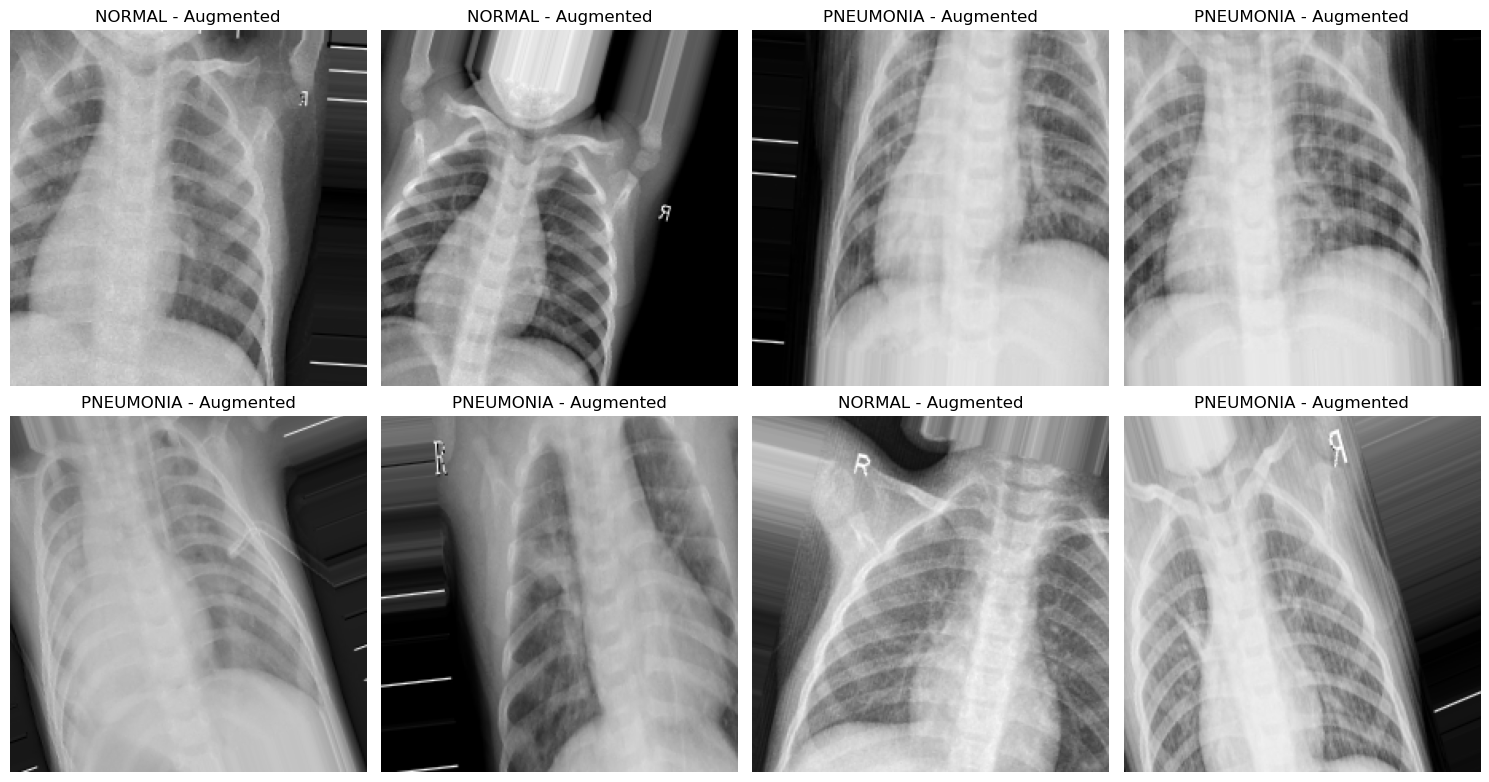

💡 Data augmentation creates variations of the same image:
   - Rotations, flips, zooms, shifts
   - Helps model generalize better
   - Especially important with class imbalance


In [9]:
# Visualize Data Augmentation
print("🎨 Visualizing data augmentation...")

def show_augmented_images(generator, num_images=8):
    # Get a batch of images
    x_batch, y_batch = next(generator)
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i in range(num_images):
        axes[i].imshow(x_batch[i])
        class_name = 'NORMAL' if y_batch[i] == 0 else 'PNEUMONIA'
        axes[i].set_title(f'{class_name} - Augmented')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("🔍 Showing augmented training images:")
show_augmented_images(train_generator)

print("💡 Data augmentation creates variations of the same image:")
print("   - Rotations, flips, zooms, shifts")
print("   - Helps model generalize better")
print("   - Especially important with class imbalance")

Build CNN Model

In [10]:
# Build CNN Model
print("🧠 Building Convolutional Neural Network...")

def create_cnn_model():
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D(2, 2),
        
        # Second Convolutional Block  
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        # Fourth Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        # Classifier
        layers.Flatten(),
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create model
model = create_cnn_model()

print("✅ CNN Model Architecture:")
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("\n🎯 Model compiled with:")
print("   Optimizer: Adam")
print("   Loss: Binary Crossentropy") 
print("   Metrics: Accuracy, Precision, Recall")

🧠 Building Convolutional Neural Network...


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)


🎯 Model compiled with:
   Optimizer: Adam
   Loss: Binary Crossentropy
   Metrics: Accuracy, Precision, Recall


Train the CNN Model

In [11]:
# Train the CNN Model
print("🏋️ Training CNN Model...")

# Calculate steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
val_steps = validation_generator.samples // BATCH_SIZE

print(f"📈 Training parameters:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training steps per epoch: {train_steps}")
print(f"   Validation steps: {val_steps}")
print(f"   Class weights: {class_weights_dict}")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,  # Start with 10 epochs
    validation_data=validation_generator,
    validation_steps=val_steps,
    class_weight=class_weights_dict,  # Handle class imbalance
    verbose=1
)

print("✅ Training completed!")

🏋️ Training CNN Model...
📈 Training parameters:
   Batch size: 32
   Training steps per epoch: 130
   Validation steps: 32
   Class weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.7858 - loss: 0.4528 - precision: 0.9261 - recall: 0.7735 - val_accuracy: 0.8545 - val_loss: 0.3150 - val_precision: 0.9262 - val_recall: 0.8739
Epoch 2/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.8438 - loss: 0.4902 - precision: 0.9091 - recall: 0.8696

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.8438 - loss: 0.4902 - precision: 0.9091 - recall: 0.8696 - val_accuracy: 0.8477 - val_loss: 0.3227 - val_precision: 0.9096 - val_recall: 0.8834
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8413 - loss: 0.3504 - precision: 0.9609 - recall: 0.8202 - val_accuracy: 0.8652 - val_loss: 0.3072 - val_precision: 0.9756 - val_recall: 0.8399
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.8750 - loss: 0.3413 - precision: 1.0000 - recall: 0.7778 - val_accuracy: 0.8594 - val_loss: 0.3028 - val_precision: 0.9572 - val_recall: 0.8495
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8515 - loss: 0.3222 - precision: 0.9670 - recall: 0.8283 - val_accuracy: 0.8818 - val_loss: 0.2640 - val_precision: 0.9419 - val_recall: 0.8961
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 212ms/step - accuracy: 0.9062 - loss: 0.7354 - precision: 0.9565 - recall: 0.9167 - val_accuracy: 0.8740 - val_loss: 0.

Plot Training History

📊 Plotting training history...


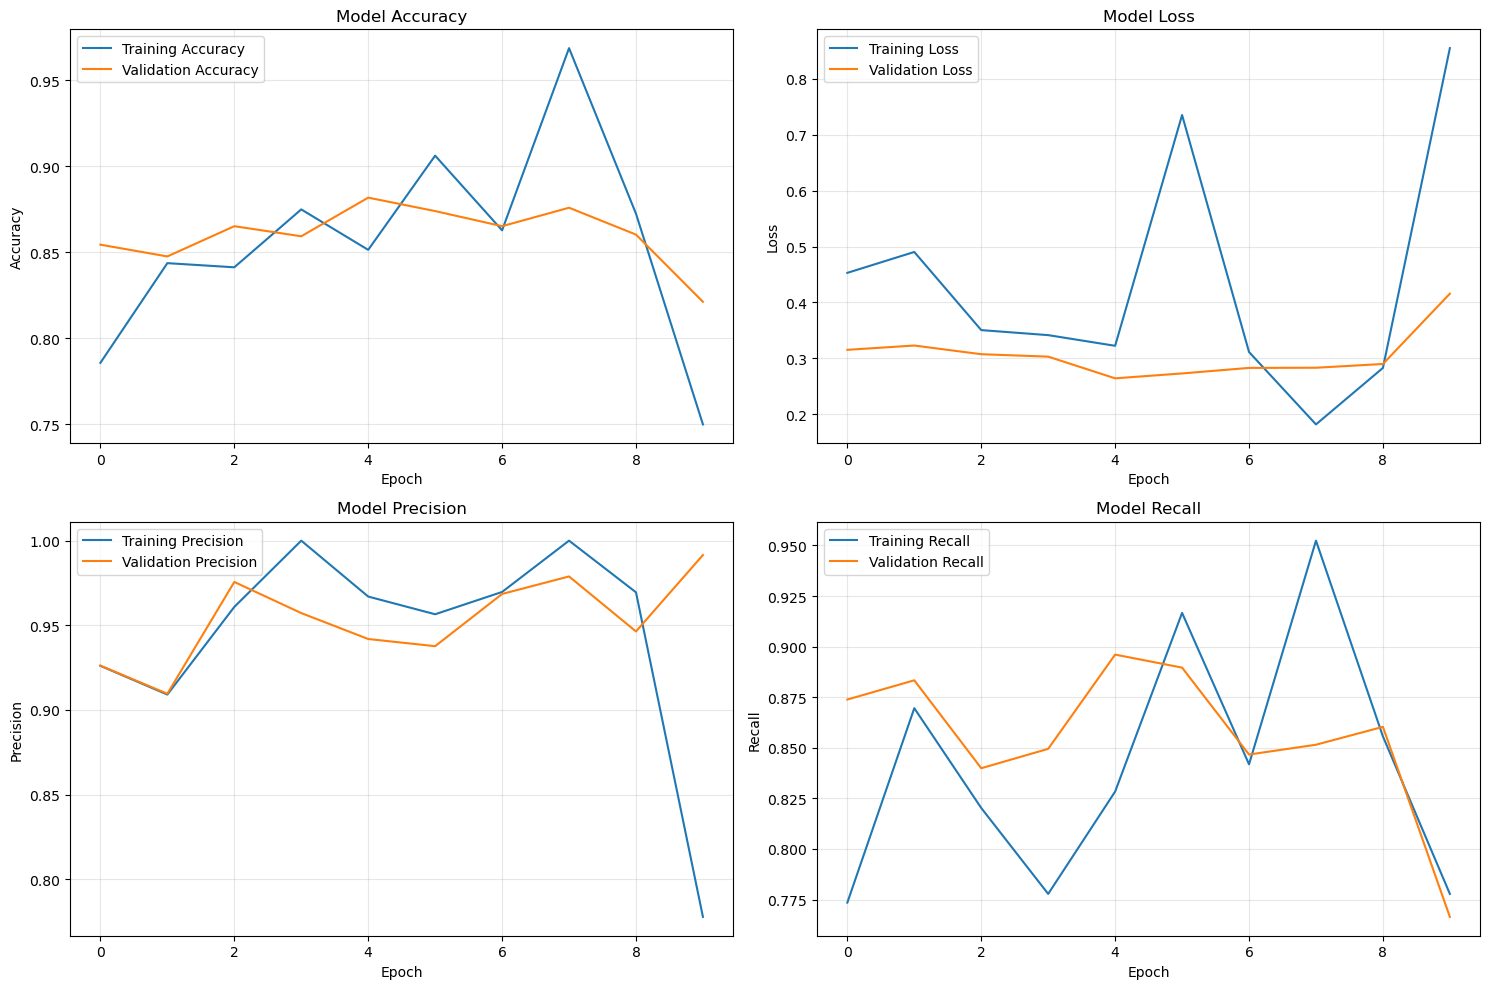

🔍 Analyzing training curves:
   - Look for convergence in accuracy/loss
   - Watch for overfitting (training >> validation)
   - Medical focus: High recall is important (don't miss pneumonia cases)


In [12]:
# Plot Training History
print("📊 Plotting training history...")

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

print("🔍 Analyzing training curves:")
print("   - Look for convergence in accuracy/loss")
print("   - Watch for overfitting (training >> validation)")
print("   - Medical focus: High recall is important (don't miss pneumonia cases)")

Evaluate Model on Test Set

In [13]:
# Evaluate Model
print("🧪 Evaluating model on test set...")

# Evaluate on test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

print(f"🎯 Test Set Performance:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall: {test_recall:.4f}")

# Calculate F1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"   F1-Score: {test_f1:.4f}")

print("\n📊 Medical Context:")
print(f"   ✅ Good accuracy for first CNN: {test_accuracy*100:.1f}%")
print(f"   🎯 Recall (sensitivity): {test_recall*100:.1f}% - Ability to detect pneumonia")
print(f"   🎯 Precision: {test_precision*100:.1f}% - Avoid false alarms")

🧪 Evaluating model on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 695ms/step - accuracy: 0.7324 - loss: 0.5410 - precision: 0.9785 - recall: 0.5846
🎯 Test Set Performance:
   Loss: 0.5410
   Accuracy: 0.7324 (73.24%)
   Precision: 0.9785
   Recall: 0.5846
   F1-Score: 0.7319

📊 Medical Context:
   ✅ Good accuracy for first CNN: 73.2%
   🎯 Recall (sensitivity): 58.5% - Ability to detect pneumonia
   🎯 Precision: 97.9% - Avoid false alarms


 Deep Performance Analysis

🔍 Deep performance analysis...
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 540ms/step
📋 Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.59      0.98      0.73       234
   PNEUMONIA       0.98      0.58      0.73       390

    accuracy                           0.73       624
   macro avg       0.78      0.78      0.73       624
weighted avg       0.83      0.73      0.73       624



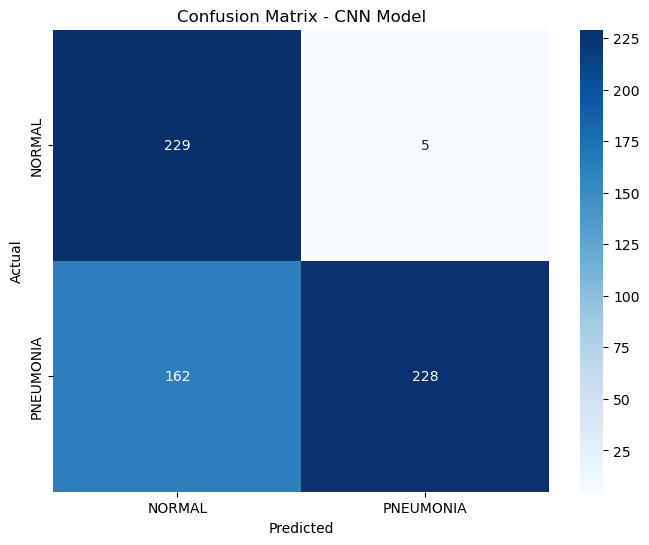

💡 Key Insight:
   The model is too conservative - it's missing many pneumonia cases
   This is dangerous in medical applications!
   We need to improve recall (sensitivity)


In [15]:
# Deep Performance Analysis
print("🔍 Deep performance analysis...")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# True labels
true_classes = test_generator.classes

# Classification report
print("📋 Detailed Classification Report:")
print(classification_report(true_classes, predicted_classes, 
                          target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("💡 Key Insight:")
print("   The model is too conservative - it's missing many pneumonia cases")
print("   This is dangerous in medical applications!")
print("   We need to improve recall (sensitivity)")

Improve Model - Adjust Classification Threshold

🎯 Improving recall by adjusting classification threshold...
📊 Performance at Different Thresholds:
   threshold  accuracy  precision  recall      f1
0        0.3    0.8109     0.9503  0.7359  0.8295
1        0.4    0.7804     0.9738  0.6667  0.7915
2        0.5    0.7324     0.9785  0.5846  0.7319
3        0.6    0.6891     0.9757  0.5154  0.6745

🎯 Recommended threshold: 0.3
   This gives recall of: 73.6%


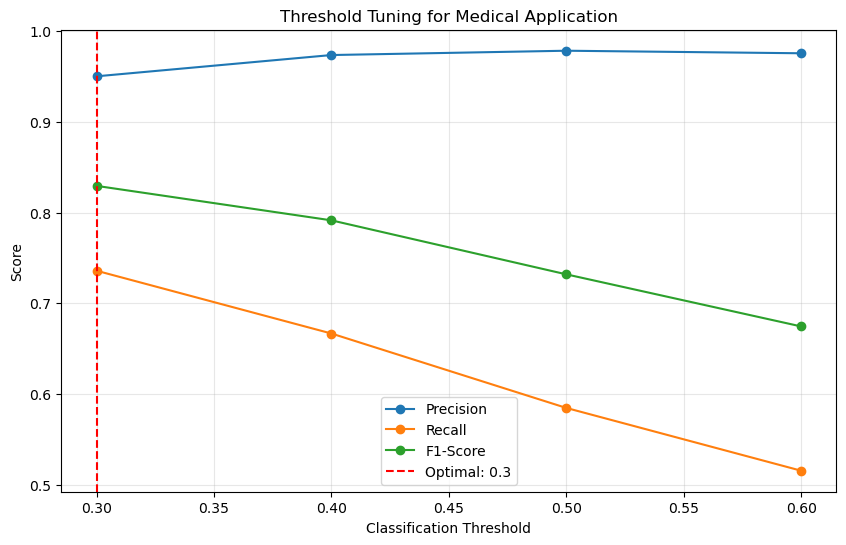

In [17]:
# Improve Recall by Adjusting Threshold
import pandas as pd
print("🎯 Improving recall by adjusting classification threshold...")

# Try different thresholds to balance precision and recall
thresholds = [0.3, 0.4, 0.5, 0.6]
results = []

for threshold in thresholds:
    predicted_classes_adj = (predictions > threshold).astype("int32").flatten()
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(true_classes, predicted_classes_adj)
    recall = recall_score(true_classes, predicted_classes_adj)
    f1 = f1_score(true_classes, predicted_classes_adj)
    accuracy = (predicted_classes_adj == true_classes).mean()
    
    results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Display results
results_df = pd.DataFrame(results)
print("📊 Performance at Different Thresholds:")
print(results_df.round(4))

# Find optimal threshold (prioritize recall for medical use)
optimal_idx = results_df['recall'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_recall = results_df.loc[optimal_idx, 'recall']

print(f"\n🎯 Recommended threshold: {optimal_threshold}")
print(f"   This gives recall of: {optimal_recall:.1%}")

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], marker='o', label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], marker='o', label='F1-Score')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal: {optimal_threshold}')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for Medical Application')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Save the Model

In [18]:
# Save Model and Results
print("💾 Saving model and results...")

# Create models directory
os.makedirs('models', exist_ok=True)

# Save the model
model.save('models/cnn_pneumonia_detector.h5')
print("✅ Model saved as: models/cnn_pneumonia_detector.h5")

# Save training history
import json
with open('models/training_history.json', 'w') as f:
    json.dump(history.history, f)
print("✅ Training history saved")

print("\n🎉 Phase 2 Complete!")
print("   First CNN model built and evaluated")
print("   Identified recall issue (critical for medical use)")
print("   Next: Transfer Learning to improve performance!")

💾 Saving model and results...
✅ Model saved as: models/cnn_pneumonia_detector.h5
✅ Training history saved

🎉 Phase 2 Complete!
   First CNN model built and evaluated
   Identified recall issue (critical for medical use)
   Next: Transfer Learning to improve performance!
